# Описание задачи и критерий оценки результата

ЧТО НУЖНО БУДЕТ СДЕЛАТЬ:

1. Скачать и загрузить датасет.
2. Отрисовать один батч загруженных данных.
3. Выбрать предобученную модель.
4. Обучить многоклассовый классификатор, используя выбранную модель.
5. Визуализировать предсказания модели.
6. Выбрать подходящие метрики качества и посчитать их для обученной модели.
7. Построить матрицу ошибок, определить, каких людей модель путает чаще всего.
8. Попробовать улучшить качество модели, решая задачу в 2 этапа: сначала выполняя детекцию лица, затем выполняя классификацию по кропу лица (для детекции можно использовать любой известный вам подход). 
9. Описать полученные результаты в текстовой ячейке ноутбука.

Основная цель: **accuracy > 0.85** на валидационной выборке.

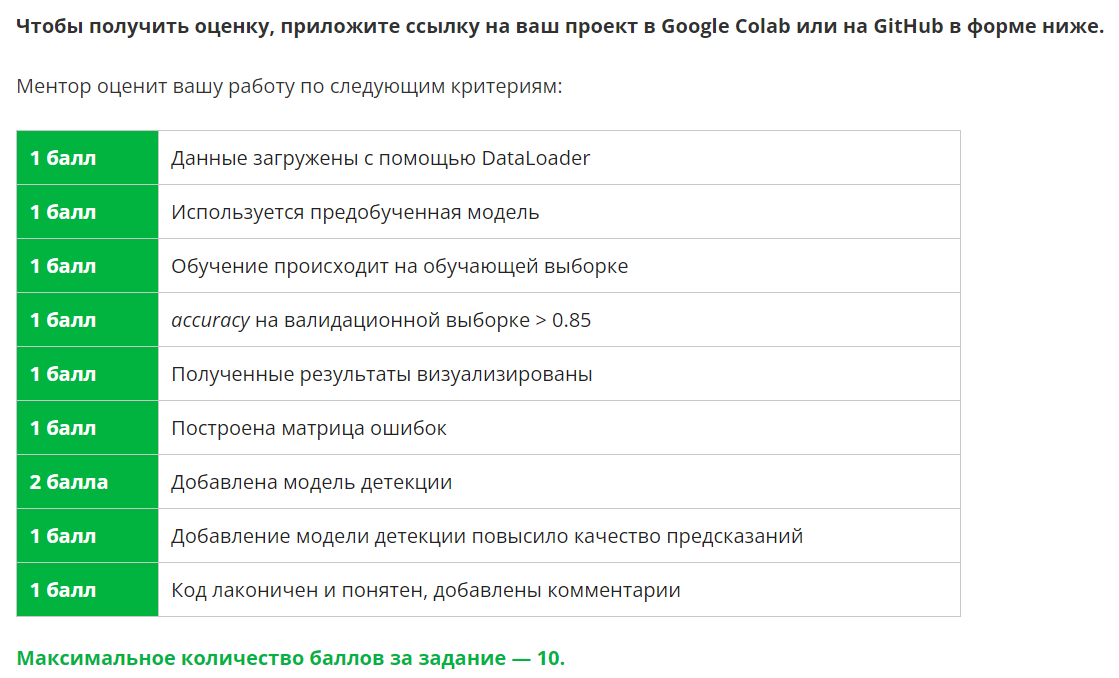

# Импорт необходимых библиотек

In [1]:
import os
import cv2
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms


# for visualization
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Загрузка данных

In [3]:
# создадим отображение int в лейблы, соответствующие знаменитостям в датасете

label_map = dict(enumerate(os.listdir('./data/train')))
print(f'Label maping: {label_map}')

# проверим, все ли размерыности изображений в датасете одинаковы

img_shape_dict = {}

for folder in os.listdir('./data'):
    for foldername in os.listdir(os.path.join('./data', folder)):
        for filename in os.listdir(os.path.join('./data', folder, foldername)):
            f = os.path.join('./data', folder, foldername, filename)
            if os.path.isfile(f):
                img_shape = cv2.imread(f).shape
                try:
                    img_shape_dict[str(img_shape)] += 1
                except:
                    img_shape_dict[str(img_shape)] = 1
                    
print(f'Shape of images: {img_shape_dict}')

Label maping: {0: 'bill_gates', 1: 'elon_musk', 2: 'jeff_bezos', 3: 'mark_zuckerberg', 4: 'steve_jobs'}
Shape of images: {'(70, 70, 3)': 3913, '(285, 229, 3)': 1}


In [16]:
# так как в датасете присутствуют в основном изображения 70х70,
# то будем проводить resize всех подаваемых в модель изображений

train_transforms = transforms.Compose(
    [
        transforms.Resize((70, 70)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # переводим изображение в PyTorch tensor
        # далее будем использовать предобученную модель Resnet, поэтому нормализуем
        # изображения с теми же коэффициентами, что и в ImageNet, на котором обучали Resnet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose([
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [10]:
path_to_data = 'data'

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

In [18]:
# def get_subset(indices, start, end):
#     return indices[start : start + end]

# TEST_PCT, VALIDATION_PCT = 0.5, 0.5
# test_count = int(len(test_data) * TEST_PCT)
# validation_count = int(len(test_data) * VALIDATION_PCT)

# indices = torch.randperm(len(test_data))

# validation_indices = get_subset(indices, 0, validation_count)
# test_indices = get_subset(indices, validation_count, test_count)

In [19]:
batch_size = 8

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 376
Number of batches in test subset:  115


In [12]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [15]:
# получим батч из тренировочных данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)

AttributeError: shape

# Использование предобученной модели Resnet

In [12]:
# опишем цикл обучения

def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / batch_size

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Записываем в тензорборд
    summary_writer.add_scalar(
        'train/loss',
        train_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'train/accuracy',
        train_accuracy,
        epoch_n
    )

In [13]:
# опишем цикл для валидации/теста

def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_scalar(
        'test/loss',
        test_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'test/accuracy',
        correct,
        epoch_n
    )
    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

## Transfer learning Resnet

In [14]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model_freeze_conv = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# заморозим веса всей модели
for param in model_freeze_conv.parameters():
    param.requires_grad = False

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model_freeze_conv.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model_freeze_conv.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model_freeze_conv = model_freeze_conv.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
optimizer = optim.SGD(model_freeze_conv.fc.parameters(), lr=0.001, momentum=0.9)

C:\Users\Home\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
%reload_ext tensorboard

In [15]:
%load_ext tensorboard

In [16]:
num_of_epochs = 10

writer = SummaryWriter('runs/resnet_ft')

for epoch_n in range(num_of_epochs):
    train_loop(train_dataloader, model_freeze_conv, loss_fn, optimizer, num_of_epochs, device, writer)
    test_loop(test_dataloader, model_freeze_conv, loss_fn, num_of_epochs, device, writer)

writer.close()
print("Done!")

  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.779, Avg loss: 0.638135 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.794, Avg loss: 0.612781 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.789, Avg loss: 0.602750 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.807, Avg loss: 0.569594 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.805, Avg loss: 0.547263 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.814, Avg loss: 0.504490 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.827, Avg loss: 0.531790 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.839, Avg loss: 0.461870 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.826, Avg loss: 0.535018 



  0%|          | 0/376 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.855, Avg loss: 0.464296 

Done!


In [26]:
%tensorboard --logdir runs/

Reusing TensorBoard on port 6006 (pid 33256), started 2:49:28 ago. (Use '!kill 33256' to kill it.)

## Fine tuning Resnet

In [ ]:
# инициализируем предобученную модель Resnet для последующего переноса обучения
model = models.resnet18(weights=torchvision.models.resnet.ResNet18_Weights)

# создадим переменную, в которую запишем количество входных признаков для последнего слоя
# модели, являющегося итоговым классификатором (classification head модели)
number_of_features = model.fc.in_features

# производим замену classification head и указываем необходимое количество выходных классов
model.fc = nn.Linear(number_of_features, len(label_map))

# отправляем модель на устройство (в нашем случае GPU)
model = model.to(device)

# инициализируем функцию потерь
loss_fn = nn.CrossEntropyLoss()

# в качестве оптимизатора указываем SGD с momentum, который использовался в оригинальной модели Resnet
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Добавление face detection

In [4]:
!mkdir face_detector
# !wget "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" -q -O ./face_detector/model.caffemodel
# !wget "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt" -q -O ./face_detector/model.prototxt

!curl -so ./face_detector/model.caffemodel "https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel" 
!curl -so ./face_detector/model.prototxt "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt"

Подпапка или файл face_detector уже существует.


In [5]:
PATH_TO_WEIGHTS = './face_detector/model.caffemodel'
PATH_TO_PROTOTXT = './face_detector/model.prototxt'

net = cv2.dnn.readNetFromCaffe(PATH_TO_PROTOTXT, PATH_TO_WEIGHTS)

In [6]:
def detect_face(img):
    img = np.asarray(img)
    h, w = img.shape[:2]
    blob = cv2.dnn.blobFromImage(
                img,
                1.0,
                (300, 300), (104.0, 177.0, 123.0)
            )

    net.setInput(blob)
    detections = net.forward()
    img_copy = img.copy()
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.3:
            box = (detections[0, 0, i, 3:7] * np.array([w, h, w, h])).astype(np.int32)
            crop = img_copy[box[1]:box[3], box[0]:box[2]]
            break
    return Image.fromarray(img_copy)

In [63]:
img = detect_face(cv2.imread('./data/train/bill_gates/00715f3e-b281-4199-91c7-7da7a8475d7b.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


<class 'numpy.ndarray'>


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [7]:
# так как в датасете присутствуют в основном изображения 70х70,
# то будем проводить resize всех подаваемых в модель изображений

train_transforms = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # переводим изображение в PyTorch tensor
        # далее будем использовать предобученную модель Resnet, поэтому нормализуем
        # изображения с теми же коэффициентами, что и в ImageNet, на котором обучали Resnet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Lambda(detect_face),
        transforms.Resize((70, 70)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [8]:
path_to_data = 'data'

training_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'train'),
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    os.path.join(path_to_data, 'valid'),
    transform=test_transforms
)

In [9]:
batch_size = 8

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f'Number of batches in train subset: {len(train_dataloader)}')
print(f'Number of batches in test subset:  {len(test_dataloader)}')

Number of batches in train subset: 376
Number of batches in test subset:  115


In [10]:
# функция для отображения изображений
def imshow(img):
    plt.figure(figsize=(16, 4))
    img = img.numpy().transpose((1, 2, 0))
    # проведем операцию, обратную нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

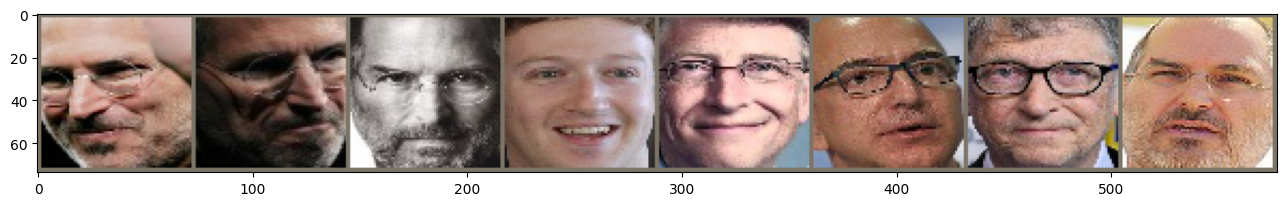

In [11]:
# получим батч из тренировочнх данных
inputs, classes = next(iter(train_dataloader))

# и отобразим его
out = torchvision.utils.make_grid(inputs)
imshow(out)